# Imports

In [1]:
import sys

sys.path.append("/home/localssk23/panoptica")

import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from panoptica import InputType
from panoptica.panoptica_evaluator import Panoptica_Evaluator
from panoptica.instance_approximator import ConnectedComponentsInstanceApproximator
from panoptica.instance_matcher import NaiveThresholdMatching, MaxBipartiteMatching

from panoptica.utils.segmentation_class import SegmentationClassGroups
from panoptica.utils.label_group import LabelMergeGroup, LabelPartGroup

# Plotting function

In [5]:
def plot_masks(pred, ref):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Create a colormap with distinct pastel colors for each class
    classes = np.unique(np.concatenate([pred.flatten(), ref.flatten()]))
    classes = classes[classes != 0]  # Remove background class (0)

    # Define pastel colors - using a pastel color palette
    pastel_colors = [
        "#FFC3A0",
        "#FFAFCC",
        "#A0C4FF",
        "#9BF6FF",
        "#CAFFBF",
        "#FDFFB6",
        "#FFD6A5",
        "#BDB2FF",
        "#FFC6FF",
        "#FFFFFC",
    ]

    # If we have more classes than colors, cycle through the pastel colors
    colors = [pastel_colors[i % len(pastel_colors)] for i in range(len(classes))]

    # Create custom colormap
    cmap = plt.cm.colors.ListedColormap(["white"] + colors)
    bounds = np.arange(len(classes) + 2) - 0.5
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Plot masks
    im0 = ax[0].imshow(pred, cmap=cmap, norm=norm, interpolation="nearest")
    ax[0].set_title("Predicted Masks")

    im1 = ax[1].imshow(ref, cmap=cmap, norm=norm, interpolation="nearest")
    ax[1].set_title("Reference Masks")

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im1, cax=cbar_ax)

    # Set ticks and labels for colorbar
    class_labels = []
    for c in classes:
        if c == 1:
            class_labels.append("class_1")
        elif c == 2:
            class_labels.append("class_2")
        elif c == 3:
            class_labels.append("class_3")
        elif c == 4:
            class_labels.append("class_4")
        else:
            class_labels.append(f"class_{int(c)}")

    cbar.set_ticks(classes)
    cbar.set_ticklabels(class_labels)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Score Functions

In [6]:
def print_scores(pred_masks, ref_masks):

    groups = {
        "class_1": (1, False),
        "class_2": (2, False),
        "class_3": (3, False),
        "class_4": (4, True),
        "Merge": LabelMergeGroup([1, 2], False),
        "Part": LabelPartGroup([1], [2], False),
    }
    class_groups = SegmentationClassGroups(groups)
    print()

    pred_masks = pred_masks.astype(np.int32)
    ref_masks = ref_masks.astype(np.int32)

    evaluator = Panoptica_Evaluator(
        expected_input=InputType.SEMANTIC,
        instance_approximator=ConnectedComponentsInstanceApproximator(),
        instance_matcher=NaiveThresholdMatching(),
        segmentation_class_groups=class_groups,
    )

    results = evaluator.evaluate(pred_masks, ref_masks, verbose=False)

    for class_name, result in results.items():
        if class_name == "merge" or class_name == "part":

            print(f"\n--- {class_name} ---")
            result_dict = result.to_dict()
            # Filter the dictionary to show only the most important metrics
            important_metrics = [
                "tp",
                "fp",
                "fn",
                "sq",
                "rq",
                "pq",
                "sq_dsc",
                "global_bin_dsc",
            ]
            filtered_dict = {
                k: round(v, 4) if isinstance(v, float) else v
                for k, v in result_dict.items()
                if k in important_metrics
            }
            print(filtered_dict)

        else:
            continue


def print_scores_multipart(pred_masks, ref_masks):

    groups = {
        "class_1": (1, False),
        "class_2": (2, False),
        "extra": (5, False),
        "class_3": (3, False),
        "class_4": (4, True),
        "Merge": LabelMergeGroup([1, 2], False),
        "Part": LabelPartGroup([1], [2, 5], False),
    }
    class_groups = SegmentationClassGroups(groups)
    print()

    pred_masks = pred_masks.astype(np.int32)
    ref_masks = ref_masks.astype(np.int32)

    evaluator = Panoptica_Evaluator(
        expected_input=InputType.SEMANTIC,
        instance_approximator=ConnectedComponentsInstanceApproximator(),
        instance_matcher=MaxBipartiteMatching(),
        segmentation_class_groups=class_groups,
    )

    results = evaluator.evaluate(pred_masks, ref_masks, verbose=False)

    for class_name, result in results.items():
        if class_name == "merge" or class_name == "part":

            print(f"\n--- {class_name} ---")
            result_dict = result.to_dict()
            # Filter the dictionary to show only the most important metrics
            important_metrics = [
                "tp",
                "fp",
                "fn",
                "sq",
                "rq",
                "pq",
                "sq_dsc",
                "global_bin_dsc",
            ]
            filtered_dict = {
                k: round(v, 4) if isinstance(v, float) else v
                for k, v in result_dict.items()
                if k in important_metrics
            }
            print(filtered_dict)

        else:
            continue

# Cases

### Partial Overlap - Basic Sanity Check difference between LabelMergeGroup and LabelPartGroup

In [7]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[14:19, 14:19] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[14:15, 14:19] = 2

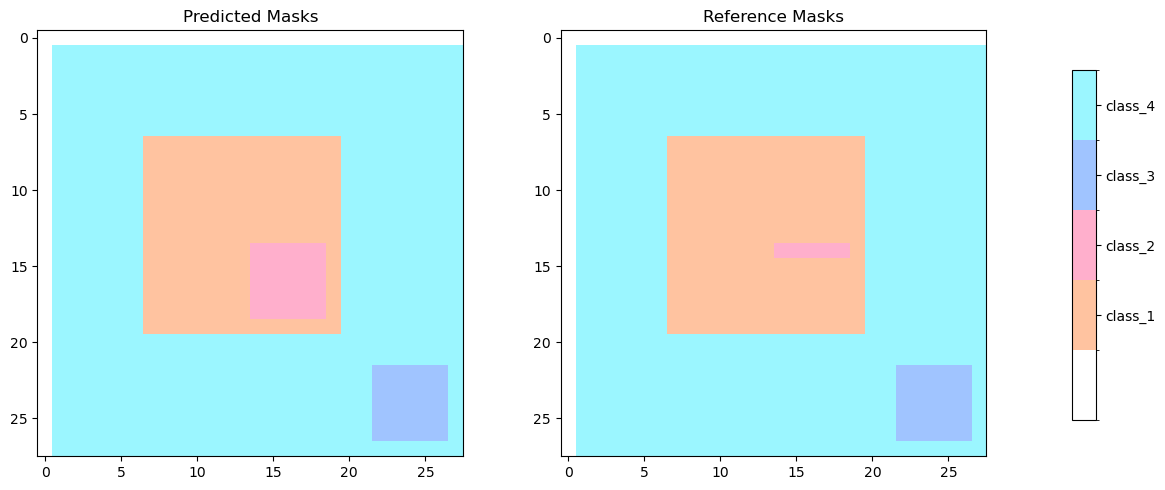

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups



────────────────────────────────────────── Thank you for using panoptica ──────────────────────────────────────────

Please support our development by citing

https://github.com/BrainLesion/panoptica#citation -- Thank you!

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2}, ref_part_types={2}
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Best score for reference part 1: 0.2
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Part type 2 individual scores: [0.2]
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Total part score: 0.2, Total part count: 1
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Both have parts - Final score: 0.6 (thing: 1.0, parts: 0.2, count: 1)
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Final sorted pairs: [(0.6, (1, 1))]

--- merge ---
{'tp': 1, 'fp': 0, 'fn': 0, 'rq': 1.0, 'sq': 1.0, 'pq': 1.0, 'sq_dsc': 1.0, 'global_bin_dsc': 1.0}

--- part ---
{'tp': 1, 'fp': 0, 'fn': 0, 'rq': 1.0, 'sq': 0.8883, 'pq': 0.8883, 'sq_dsc': 0.9408, 'global_bin_dsc': 0.6667}
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Thi

In [8]:
plot_masks(pred_masks, ref_masks)
print_scores(pred_masks, ref_masks)

### Perfect Overlap - Basic Sanity Check difference between LabelMergeGroup and LabelPartGroup

In [9]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[14:19, 14:19] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[14:19, 14:19] = 2

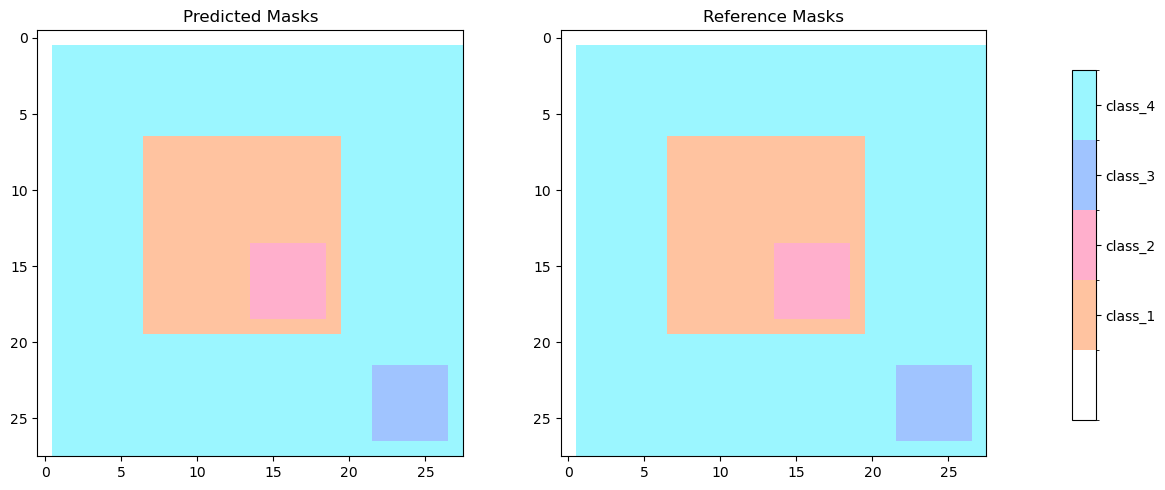

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2}, ref_part_types={2}
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Best score for reference part 1: 1.0
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Part type 2 individual scores: [1.0]
2025-06-05 09:01:32 - panoptica._functionals - DEBUG - Total part score: 1.0, Total part count: 1
2025-06-05

In [10]:
plot_masks(pred_masks, ref_masks)
print_scores(pred_masks, ref_masks)

### Isolated Part - Basic Sanity Check difference between LabelMergeGroup and LabelPartGroup

Isolated Parts shuold become a standalone panoptic instance

In [11]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:13] = 2
pred_masks[14:19, 14:19] = 2
pred_masks[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3


# Part Classes last
ref_masks[14:19, 14:19] = 2

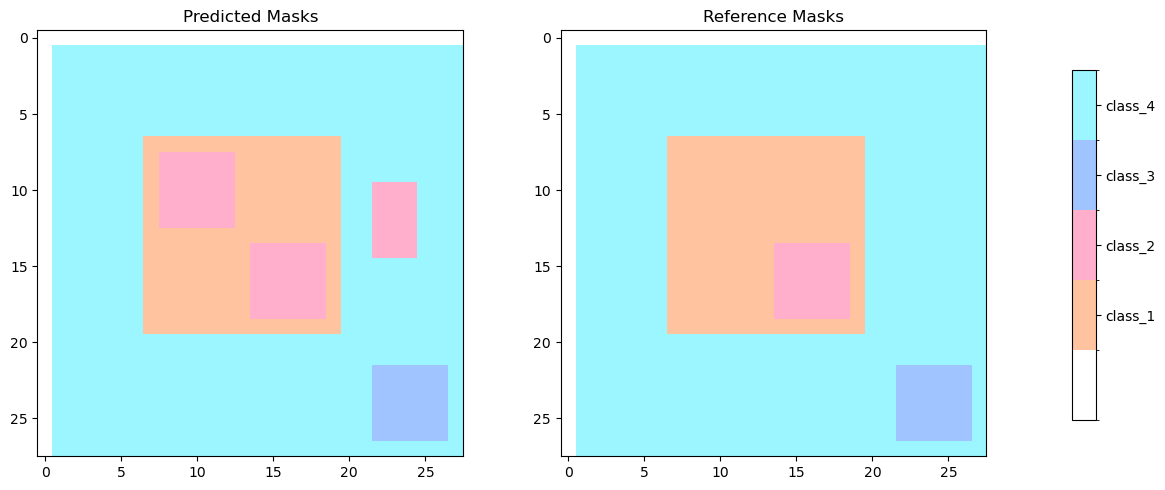

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2}, ref_part_types={2}
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Best score for reference part 1: 0.5
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Part type 2 individual scores: [0.5]
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Total part score: 0.5, Total part count: 1
2025-06-05

In [12]:
plot_masks(pred_masks, ref_masks)
print_scores(pred_masks, ref_masks)

### Edge Case (Uneven Pairs) - Panoptic-part pair where: one pair has a part and the other doesn't

In [13]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[1:4, 1:4] = 1
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:13] = 2
pred_masks[14:19, 14:19] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[1:3, 1:3] = 1
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[14:19, 14:19] = 2

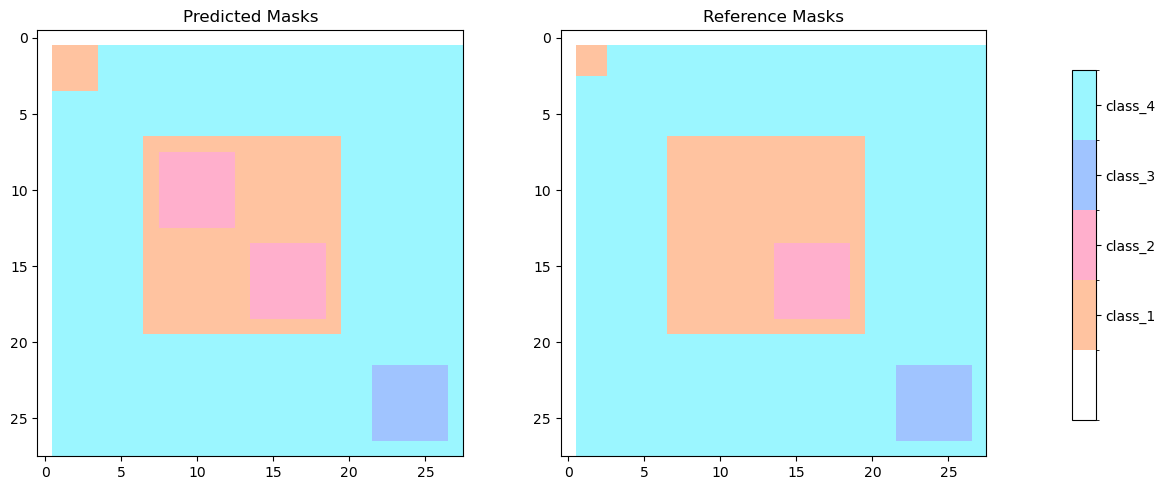

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (2, 2)), (0.4444444444444444, (1, 1))]
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Thing pair (2, 2): pred_part_types={2}, ref_part_types={2}
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Best score for reference part 1: 0.5
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (2, 2)), (0.4444444444444444, (1, 1))]
2025-06-05 09:01:33 - panoptica._functionals - DE

In [14]:
plot_masks(pred_masks, ref_masks)
print_scores(pred_masks, ref_masks)

### Edge Case (Uneven Pairs) - Panoptic-part pair where: one pair has a part and the other doesn't; with isolated part

In [15]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[1:4, 1:4] = 1
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:13] = 2
pred_masks[14:19, 14:19] = 2
pred_masks[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[1:3, 1:3] = 1
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[14:19, 14:19] = 2

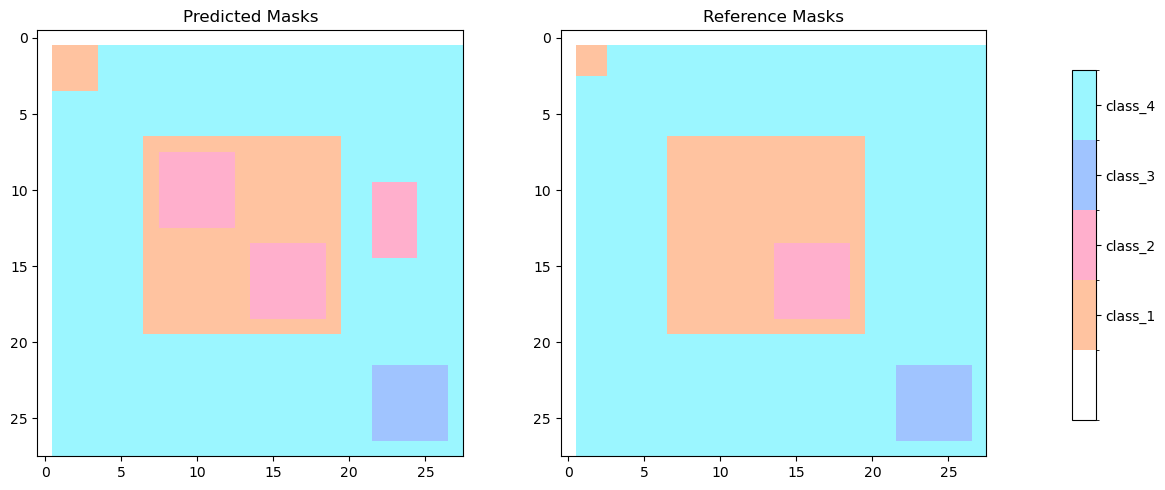

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (2, 2)), (0.4444444444444444, (1, 1))]
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Thing pair (2, 2): pred_part_types={2}, ref_part_types={2}
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Best score for reference part 1: 0.5
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Part type 2 individual scores: [0.5]
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Total part score: 0.5, 

In [16]:
plot_masks(pred_masks, ref_masks)
print_scores(pred_masks, ref_masks)

### Edge Case (Uneven Classes) - Panoptic-part pair where: pred or gt has parts, but the other doesnt.

In [17]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[1:4, 1:4] = 1
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:13] = 2
pred_masks[14:19, 14:19] = 2
pred_masks[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[1:3, 1:3] = 1
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# # Part Classes last
# ref_masks[14:19, 14:19] = 2

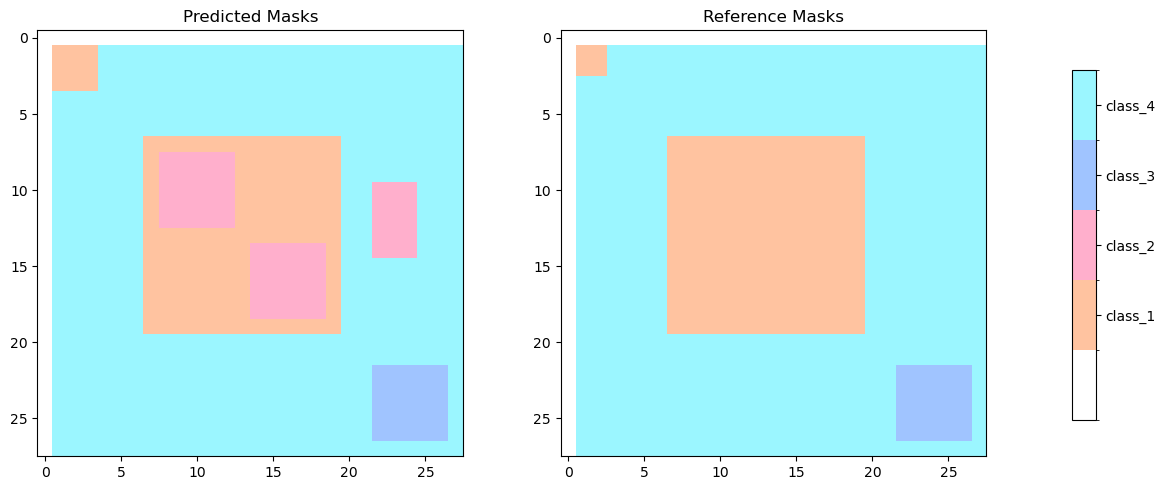

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (2, 2)), (0.4444444444444444, (1, 1))]
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Thing pair (2, 2): pred_part_types={2}, ref_part_types=set()
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Thing pair (2, 2): pred_part_types={2}, ref_part_types=set()
2025-06-05 09:01:33 - panoptica._functionals - DEBUG - Part type mismatch, using half thing score: 0.5
2025-06-05 09:01:33 - panoptica._function

In [18]:
plot_masks(pred_masks, ref_masks)
print_scores(pred_masks, ref_masks)

### Partial Overlap (Multi part pair) - Complex Sanity Check.

In [19]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:11] = 2
pred_masks[14:19, 14:18] = 5

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[8:13, 8:10] = 2
ref_masks[14:19, 14:19] = 5

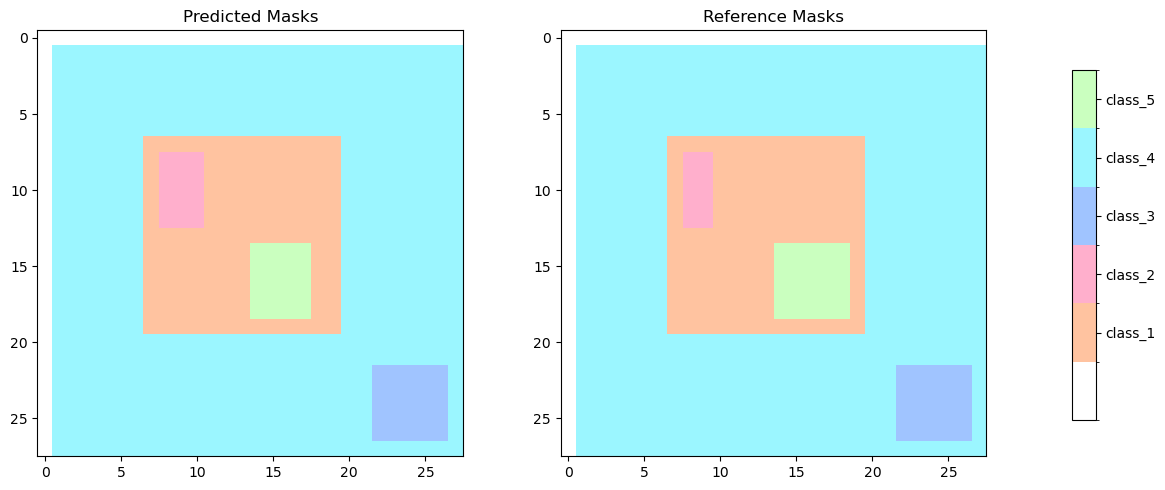

The same labels [1, 2, 5] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - extra : LabelGroup [5], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2, 5], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2, 5}, ref_part_types={2, 5}
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Best score for reference part 1: 0.6666666666666666
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Part type 2 individual scores: [0.6666666666666666]
2025-06-05 09:01:

In [20]:
plot_masks(pred_masks, ref_masks)
print_scores_multipart(pred_masks, ref_masks)

### Perfect Overlap (Multi part pair) - Complex Sanity Check.

In [21]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:10] = 2
pred_masks[14:19, 14:19] = 5

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[8:13, 8:10] = 2
ref_masks[14:19, 14:19] = 5

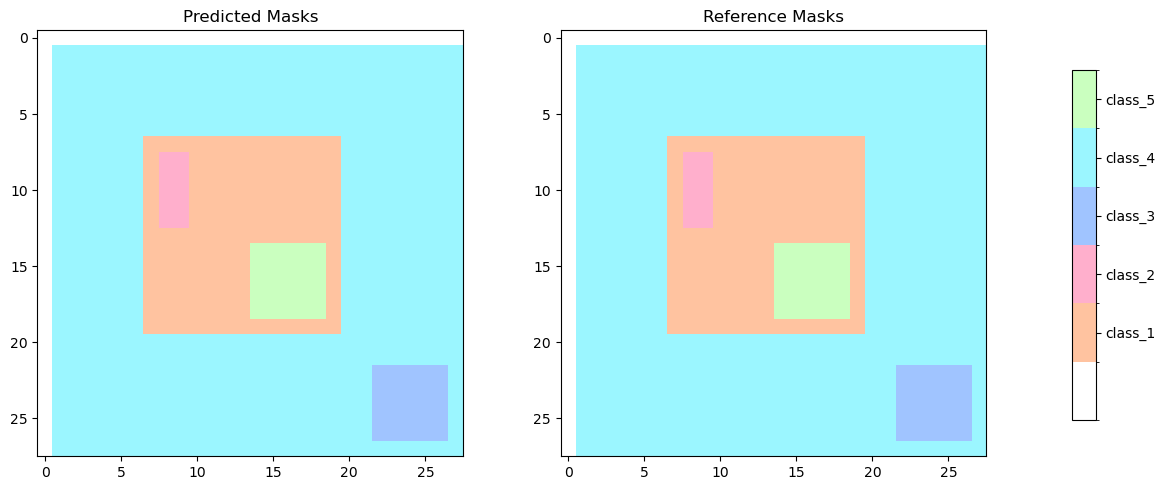

The same labels [1, 2, 5] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - extra : LabelGroup [5], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2, 5], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2, 5}, ref_part_types={2, 5}
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2, 5}, ref_part_types={2, 5}
2025-06-05 09:01:34 

In [22]:
plot_masks(pred_masks, ref_masks)
print_scores_multipart(pred_masks, ref_masks)

### Uneven Classes (Multi part pair) - Complex Sanity Check.

In [23]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[8:13, 8:11] = 2
pred_masks[14:19, 14:18] = 5

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[14:19, 14:19] = 5

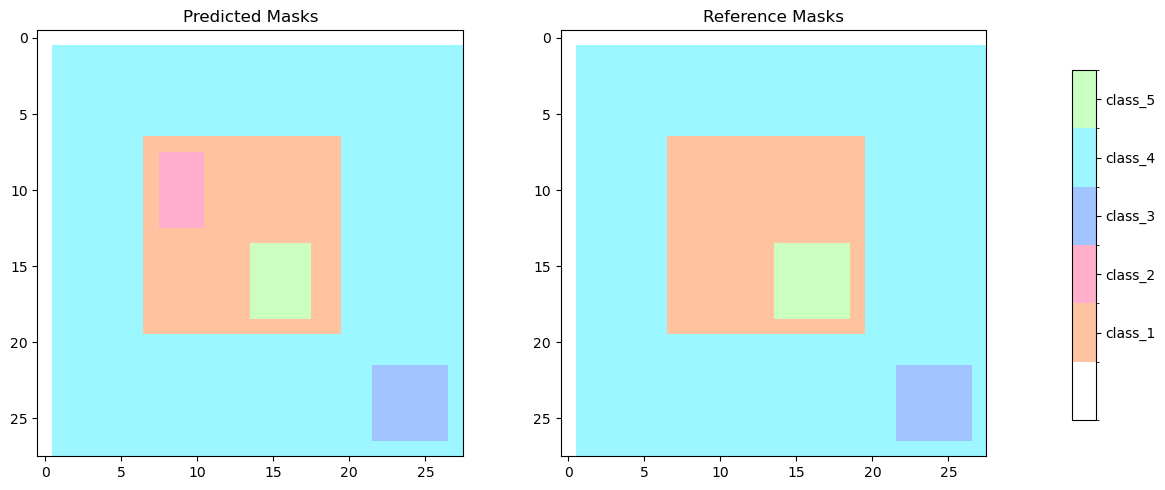

The same labels [1, 2, 5] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - extra : LabelGroup [5], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2, 5], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Sorted thing pairs: [(1.0, (1, 1))]
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types={2, 5}, ref_part_types={5}
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Part type 2 individual scores: [0.0]
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Best score for reference part 1: 0.8
2025-06-05 09:01:34 - panoptica._functionals - DEB

In [24]:
plot_masks(pred_masks, ref_masks)
print_scores_multipart(pred_masks, ref_masks)

### No Parts - Basic Sanity Check difference similarity LabelMergeGroup and LabelPartGroup

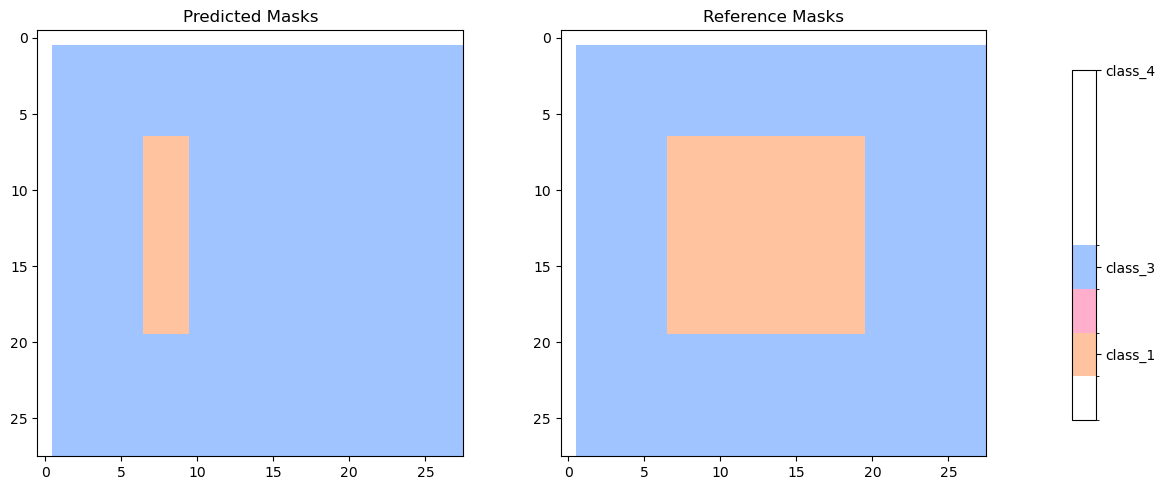

The same labels [1, 2, 5] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - extra : LabelGroup [5], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - merge : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - part : LabelPartGroup Things: [1], Parts: [2, 5], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Sorted thing pairs: [(0.23076923076923078, (1, 1))]
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Thing pair (1, 1): pred_part_types=set(), ref_part_types=set()
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - No parts, using thing score: 0.23076923076923078
2025-06-05 09:01:34 - panoptica._functionals - DEBUG - Final sorted pairs: [(0.23076923076923078, (1, 1))]

--- m

In [25]:
# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[7:20, 7:10] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last

plot_masks(pred_masks, ref_masks)
print_scores_multipart(pred_masks, ref_masks)